# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [135]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2016-06-27/data_eval_new/"
file_name = "int_norm_20160627_bgd_new.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [136]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [137]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [138]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

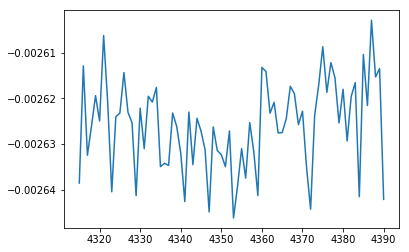

In [139]:
# Check Baselines
column = "117"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

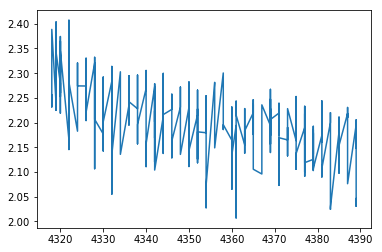

In [140]:
# Check Signals
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

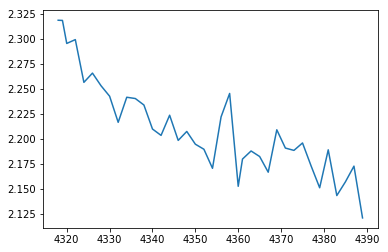

In [141]:
# Check Signals - mean
column = "122"
sample = "NIST 200ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

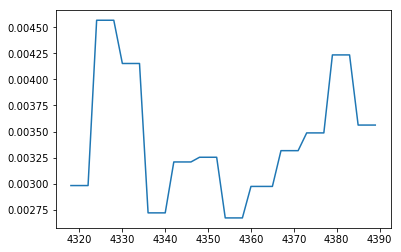

In [142]:
# Check background 
column = "118"
sample = "NIST 200ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [143]:
background_mean = df_mean(background)

# Outlier rejection

In [201]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_122_118"
interf_corr = "Te125_Xe129_corr"

In [202]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [205]:
column = "124/118"
sample = "NIST 200ppb"

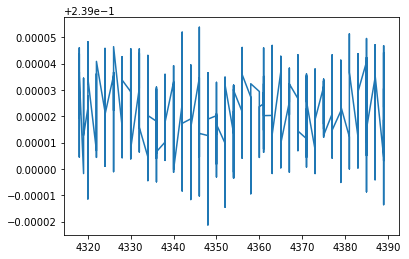

In [206]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [207]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [208]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,,,
2016-06-28 12:14:00,NIST 350ppb,2,1,4316,0.040151,0.027188,0.013939,0.600288,0.316705,0.354603,1.345837,0.19125,0.239016
2016-06-28 12:14:00,NIST 350ppb,2,2,4316,0.040146,0.027182,0.013941,0.600295,0.316697,0.354616,1.345888,0.19125,0.239030
2016-06-28 12:14:00,NIST 350ppb,2,3,4316,0.040134,0.027172,0.013941,0.600296,0.316705,0.354616,1.345883,0.19125,0.239038
2016-06-28 12:14:00,NIST 350ppb,2,4,4316,0.040141,0.027178,0.013942,0.600295,0.316704,0.354614,1.345896,0.19125,0.239034
2016-06-28 12:14:00,NIST 350ppb,2,5,4316,0.040139,0.027180,0.013942,0.600291,0.316705,0.354612,1.345902,0.19125,0.239033
2016-06-28 12:14:00,NIST 350ppb,2,6,4316,0.040147,0.027181,0.013945,0.600329,0.316715,0.354621,1.345867,0.19125,0.239023
2016-06-28 12:14:00,NIST 350ppb,2,7,4316,0.040141,0.027176,0.013942,0.600312,0.316718,0.354624,1.345956,NaN,0.239033
2016-06-28 12:14:00,NIST 350ppb,2,8,4316,0.040142,0.027181,0.013944,0.600315,0.316719,0.354622,1.345889,NaN,0.239015
2016-06-28 12:14:00,NIST 350ppb,2,9,4316,0.040137,0.027177,0.013939,0.600258,0.316715,0.354598,1.345960,0.19125,0.239017


In [209]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
4330        2016-06-28 15:18:00    0.259403
            2016-06-28 15:18:00    0.259407
4337        2016-06-28 16:52:00    0.259539
4345        2016-06-28 18:40:00    0.259636
4348        2016-06-28 19:18:00    0.259545
4349        2016-06-28 19:32:00    0.259622
            2016-06-28 19:32:00    0.259546
            2016-06-28 19:32:00    0.259539
4351        2016-06-28 20:00:00    0.259695
4360        2016-06-28 22:14:00    0.259631
4368        2016-06-29 00:21:00    0.259660
4385        2016-06-29 04:07:00    0.259763
4387        2016-06-29 04:35:00    0.259735
4388        2016-06-29 04:49:00    0.259743
Name: 124/118, dtype: float64

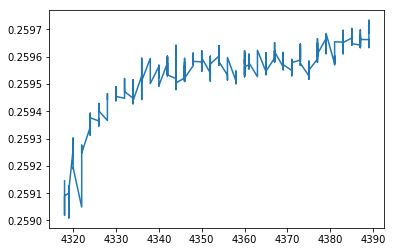

In [210]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [211]:
df[df["Sample"] == sample][column].std()

0.00015078134159635947

In [212]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

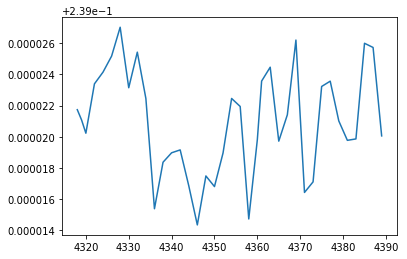

In [213]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [214]:
data_mean_int

,Filenumber,Sample,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118
Date,,,,,,,,,,,
2016-06-28 12:14:00,4316,NIST 350ppb,0.040143,0.027179,0.013943,0.600308,0.316714,0.354619,1.345906,0.19125,0.239024
2016-06-28 12:38:00,4318,NIST 200ppb,0.040144,0.027179,0.013945,0.600313,0.316719,0.354619,1.345929,0.19125,0.239022
2016-06-28 12:52:00,4319,NIST 200ppb,0.040145,0.027179,0.013943,0.600324,0.316721,0.354618,1.345919,0.19125,0.239021
2016-06-28 13:06:00,4320,NIST 200ppb,0.040149,0.027184,0.013944,0.600338,0.316725,0.354622,1.345927,0.19125,0.239020
2016-06-28 13:20:00,4321,NIST 350ppb,0.040147,0.027180,0.013945,0.600326,0.316721,0.354618,1.345922,0.19125,0.239020
2016-06-28 13:34:00,4322,NIST 200ppb,0.040146,0.027178,0.013945,0.600327,0.316725,0.354622,1.345943,0.19125,0.239023
2016-06-28 13:58:00,4324,NIST 200ppb,0.040148,0.027180,0.013945,0.600330,0.316726,0.354616,1.345937,0.19125,0.239024
2016-06-28 14:12:00,4325,NIST 200ppb + 0.440ppb Mo,0.040145,0.027177,0.013945,0.600327,0.316724,0.354619,1.345930,0.19125,0.239024
2016-06-28 14:26:00,4326,NIST 200ppb,0.040146,0.027176,0.013944,0.600325,0.316723,0.354621,1.345940,0.19125,0.239025


In [215]:
date_list = []
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [216]:
drop_sum = []

In [217]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [218]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [219]:
data_mean_int_sum

112/118                       114/118  \
                               mean           SD2 count      mean   
Sample                                                              
NIST 200ppb                0.040147  4.734101e-06    38  0.027178   
NIST 200ppb + 0.001ppb In  0.040144           NaN     1  0.027174   
NIST 200ppb + 0.005ppb U   0.040146  2.335377e-06     2  0.027178   
NIST 200ppb + 0.010ppb Cd  0.040147           NaN     1  0.027180   
NIST 200ppb + 0.015ppb U   0.040148           NaN     1  0.027180   
NIST 200ppb + 0.03ppb Cd   0.040148  1.349952e-06     2  0.027182   
NIST 200ppb + 0.040ppb Cd  0.040148           NaN     1  0.027183   
NIST 200ppb + 0.056ppb Zr  0.040147  1.582668e-06     2  0.027176   
NIST 200ppb + 0.082ppb Rh  0.040146  7.488578e-06     2  0.027178   
NIST 200ppb + 0.109ppb Ru  0.040149  3.457186e-06     2  0.027182   
NIST 200ppb + 0.250ppb Pd  0.040145  4.686495e-06     2  0.027176   
NIST 200ppb + 0.440ppb Mo  0.040145  8.428249e-07     2  0.027177   
NIST 200ppb + ME           0.040148  4.162028e-06     2  0.027178   
NIST 350ppb                0.040145  6.010122e-06     2  0.027179   
ZH09-05 23.3_1_5           0.040151           NaN     1  0.027180   
ZH09-05_23.3_1_4           0.040147           NaN     1  0.027180   

                                                115/118                      \
                                    SD2 count      mean           SD2 count   
Sample                                                                        
NIST 200ppb                5.044249e-06    38  0.013946  2.536108e-06    38   
NIST 200ppb + 0.001ppb In           NaN     1  0.013969           NaN     1   
NIST 200ppb + 0.005ppb U   2.865284e-06     2  0.013946  2.737218e-06     2   
NIST 200ppb + 0.010ppb Cd           NaN     1  0.013946           NaN     1   
NIST 200ppb + 0.015ppb U            NaN     1  0.013947           NaN     1   
NIST 200ppb + 0.03ppb Cd   6.328858e-07     2  0.013946  7.274538e-07     2   
NIST 200ppb + 0.040ppb Cd           NaN     1  0.013946           NaN     1   
NIST 200ppb + 0.056ppb Zr  7.650699e-06     2  0.013946  1.461014e-06     2   
NIST 200ppb + 0.082ppb Rh  4.086782e-06     2  0.013946  1.877772e-07     2   
NIST 200ppb + 0.109ppb Ru  4.265906e-06     2  0.013946  1.901208e-07     2   
NIST 200ppb + 0.250ppb Pd  2.235342e-06     2  0.013946  1.786567e-06     2   
NIST 200ppb + 0.440ppb Mo  1.167551e-06     2  0.013945  6.114182e-08     2   
NIST 200ppb + ME           8.844044e-06     2  0.013945  1.335574e-06     2   
NIST 350ppb                2.068128e-06     2  0.013944  2.889404e-06     2   
ZH09-05 23.3_1_5                    NaN     1  0.013944           NaN     1   
ZH09-05_23.3_1_4                    NaN     1  0.013943           NaN     1   

                            116/118  ...  119/118   120/118                  \
                               mean  ...    count      mean       SD2 count   
Sample                               ...                                      
NIST 200ppb                0.600335  ...       38  1.345937  0.000015    38   
NIST 200ppb + 0.001ppb In  0.600330  ...        1  1.345942       NaN     1   
NIST 200ppb + 0.005ppb U   0.600336  ...        2  1.345932  0.000001     2   
NIST 200ppb + 0.010ppb Cd  0.600328  ...        1  1.345952       NaN     1   
NIST 200ppb + 0.015ppb U   0.600337  ...        1  1.345936       NaN     1   
NIST 200ppb + 0.03ppb Cd   0.600338  ...        2  1.345940  0.000040     2   
NIST 200ppb + 0.040ppb Cd  0.600338  ...        1  1.345939       NaN     1   
NIST 200ppb + 0.056ppb Zr  0.600336  ...        2  1.345943  0.000004     2   
NIST 200ppb + 0.082ppb Rh  0.600328  ...        2  1.345944  0.000030     2   
NIST 200ppb + 0.109ppb Ru  0.600336  ...        2  1.345940  0.000007     2   
NIST 200ppb + 0.250ppb Pd  0.600334  ...        2  1.345938  0.000019     2   
NIST 200ppb + 0.440ppb Mo  0.600333  ...        2  1.345933  0.000007     2   
NIST 200ppb + ME           0.

In [220]:
date_list = []


epsilon_int_200 = SSB(data_mean_int.drop(date_list), "NIST 200ppb", 10000)
delta_raw_200 = SSB(data_mean_raw.drop(date_list), "NIST 200ppb", 1000)

In [221]:

date_list = [pd.Timestamp('2016-06-28 12:52:00'),
             pd.Timestamp('2016-06-28 13:06:00'),
             pd.Timestamp('2016-06-28 19:18:00')]

epsilon_int_200 = epsilon_int_200.drop(date_list)
delta_raw_200 = delta_raw_200.drop(date_list)

In [222]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -10) & (df["Filenumber"] <= 10)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [223]:
epsilon_int_200 = epsilon_process(epsilon_int_200)
delta_raw_200 = epsilon_process(delta_raw_200)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [224]:
epsilon_int_200

,Filenumber,112/118,114/118,115/118,116/118,117/118,119/118,120/118,122/118,124/118,Sample
Date,,,,,,,,,,,
2016-06-28 13:20:00,4321,-0.095749,-0.204088,0.069479,-0.109431,-0.128378,-0.130710,-0.098596,2.220446e-12,-0.072422,NIST 350ppb
2016-06-28 13:34:00,4322,-0.654240,-1.489766,0.422710,-0.112532,-0.012078,0.085521,0.079276,6.661338e-12,0.050530,NIST 200ppb
2016-06-28 13:58:00,4324,0.508328,0.930878,0.326010,0.074529,0.047989,-0.149572,-0.034230,-5.551115e-12,-0.005735,NIST 200ppb
2016-06-28 14:12:00,4325,-0.390384,-0.359446,0.238235,-0.007923,-0.011184,0.010850,-0.059457,0.000000e+00,-0.016293,NIST 200ppb + 0.440ppb Mo
2016-06-28 14:26:00,4326,-0.689442,-1.304278,-0.207506,-0.106018,-0.069097,0.081698,-0.002572,4.440892e-12,-0.017319,NIST 200ppb
2016-06-28 14:40:00,4327,-0.084111,-0.775192,1.451744,0.088384,0.134350,-0.005379,-0.080335,-3.330669e-12,-0.099380,NIST 200ppb + 0.250ppb Pd
2016-06-28 14:54:00,4328,1.222403,1.396918,0.250895,0.096551,0.097064,0.077108,0.066369,-3.330669e-12,0.120028,NIST 200ppb
2016-06-28 15:18:00,4330,-1.290510,-0.696095,-0.898408,-0.165101,-0.121150,-0.148612,-0.062286,2.220446e-12,-0.129010,NIST 200ppb
2016-06-28 15:32:00,4331,-0.081436,0.297586,1.165860,0.066829,0.031714,0.137355,0.029782,-1.110223e-12,0.095954,NIST 200ppb + 0.440ppb Mo


In [225]:
epsilon_int_200_sum = np.round(epsilon_int_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_200_sum = np.round(delta_raw_200.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_int_200_sum
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_200_sum
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [226]:
epsilon_sum_all

112/118              114/118              115/118  \
                             mean    SD2 count    mean    SD2 count    mean   
Sample                                                                        
NIST 200ppb                 0.040  1.342    33   0.058  2.109    33   0.036   
NIST 200ppb + 0.001ppb In  -0.870    NaN     1  -0.486    NaN     1  17.552   
NIST 200ppb + 0.005ppb U   -0.279  0.566     2   0.133  0.814     2  -0.029   
NIST 200ppb + 0.010ppb Cd  -0.097    NaN     1   1.205    NaN     1  -0.754   
NIST 200ppb + 0.015ppb U    0.310    NaN     1   0.710    NaN     1  -0.209   
NIST 200ppb + 0.03ppb Cd   -0.110  0.639     2   1.347  0.271     2  -0.456   
NIST 200ppb + 0.040ppb Cd   0.290    NaN     1   2.454    NaN     1   0.567   
NIST 200ppb + 0.056ppb Zr  -0.051  1.386     2  -0.825  0.776     2   0.157   
NIST 200ppb + 0.082ppb Rh  -0.083  0.079     2  -0.150  0.266     2   0.301   
NIST 200ppb + 0.109ppb Ru   0.123  0.227     2   0.797  0.391     2  -0.083   
NIST 200ppb + 0.250ppb Pd  -0.445  1.021     2  -0.730  0.129     2   0.834   
NIST 200ppb + 0.440ppb Mo  -0.236  0.437     2  -0.031  0.929     2   0.702   
NIST 200ppb + ME           -0.278  0.845     2  -1.016  1.025     2  -0.915   
NIST 350ppb                -0.096    NaN     1  -0.204    NaN     1   0.069   
ZH09-05 23.3_1_5            0.200    NaN     1  -0.528    NaN     1  -2.727   
ZH09-05_23.3_1_4           -0.361    NaN     1  -0.050    NaN     1  -2.219   

                                       116/118  ...  119/118 120/118         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
NIST 200ppb                1.371    33  -0.006  ...       33   0.006  0.095   
NIST 200ppb + 0.001ppb In    NaN     1  -0.105  ...        1  -0.008    NaN   
NIST 200ppb + 0.005ppb U   0.028     2  -0.037  ...        2  -0.025  0.133   
NIST 200ppb + 0.010ppb Cd    NaN     1  -0.137  ...        1   0.090    NaN   
NIST 200ppb + 0.015ppb U     NaN     1   0.063  ...        1  -0.006    NaN   
NIST 200ppb + 0.03ppb Cd   0.133     2   0.009  ...        2   0.039  0.211   
NIST 200ppb + 0.040ppb Cd    NaN     1  -0.001  ...        1  -0.025    NaN   
NIST 200ppb + 0.056ppb Zr  1.771     2   0.006  ...        2   0.012  0.035   
NIST 200ppb + 0.082ppb Rh  0.486     2  -0.104  ...        2   0.044  0.073   
NIST 200ppb + 0.109ppb Ru  0.819     2   0.009  ...        2   0.020  0.001   
NIST 200ppb + 0.250ppb Pd  1.746     2   0.032  ...        2  -0.000  0.227   
NIST 200ppb + 0.440ppb Mo  1.312     2   0.029  ...        2  -0.015  0.126   
NIST 200ppb + ME           2.369     2   0.095  ...        2  -0.068  0.080   
NIST 350ppb                  NaN     1  -0.109  ...        1  -0.099    NaN   
ZH09-05 23.3_1_5             NaN     1  -0.002  ...        1  -0.008    NaN   
ZH09-05_23.3_1_4             NaN     1  -0.160  ...        1  -0.001    NaN   

                                122/118            124/118               
                          count    mean  SD2 count    mean    SD2 count  
Sample                                                                   
NIST 200ppb                  33     0.0  0.0    33   0.003  0.244    33  
NIST 200ppb + 0.001ppb In     1    -0.0  NaN     1   0.082    NaN     1  
NIST 200ppb + 0.005ppb U      2     0.0  0.0     2   0.025  0.291     2  
NIST 200ppb + 0.010ppb Cd     1     0.0  NaN     1   0.041    NaN     1  
NIST 200ppb + 0.015ppb U      1     0.0  NaN     1  -0.253    NaN     1  
NIST 200ppb + 0.03ppb Cd      2    -0.0  0.0     2  -0.003  0.193     2  
NIST 200ppb + 0.040ppb Cd     1    -0.0  NaN     1  -0.076    NaN     1  
NIST 200ppb + 0.056ppb Zr     2    -0.0  0.0     2   0.041  0.002     2  
NIST 200ppb + 0.082ppb Rh     2     0.0  0.0     2   0.177  0.274     2  
NIST 200ppb + 0.109ppb Ru     2     0.0  0.0     2   0.114  0.428     2  
NIST 200ppb + 0.250ppb Pd     2    -0.0  0.0     2  -0.026  

In [192]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_200, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

# Raw data to xls file

In [198]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [199]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [227]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new.xlsx', engine='xlsxwriter')


In [228]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_200.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_200.to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [229]:
writer_orig.save()

In [230]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [231]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')